In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv('bank-additional-full.csv', delimiter=';')
df.rename(columns={
    'y': 'subscribed',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'euribor3m': 'euribor_3month_rate',
    'nr.employed': 'number_of_employees',
    'emp.var.rate': 'employment_variation_rate'
}, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3month_rate,number_of_employees,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Analysis

In [2]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        41188 non-null  int64  
 1   job                        41188 non-null  object 
 2   marital                    41188 non-null  object 
 3   education                  41188 non-null  object 
 4   default                    41188 non-null  object 
 5   housing                    41188 non-null  object 
 6   loan                       41188 non-null  object 
 7   contact                    41188 non-null  object 
 8   month                      41188 non-null  object 
 9   day_of_week                41188 non-null  object 
 10  duration                   41188 non-null  int64  
 11  campaign                   41188 non-null  int64  
 12  pdays                      41188 non-null  int64  
 13  previous                   41188 non-null  int

In [3]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'subscribed']

for column in categorical_columns:
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in subscribed: ['no' 'yes']


In [4]:
df['education'] = df['education'].replace({
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'basic.9y': 'basic'
})

categorical_features = ['job', 'marital', 'education']
for feature in categorical_features:
    df[feature] = df[feature].replace({'unknown': df[feature].mode()[0]})

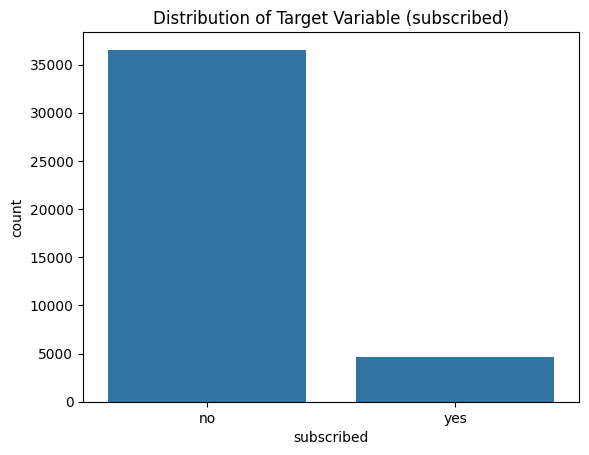

In [5]:
sns.countplot(x='subscribed', data=df)
plt.title('Distribution of Target Variable (subscribed)')
plt.show()

In [6]:
print(df['subscribed'].value_counts(normalize=True) * 100)

subscribed
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


In [7]:
numerical_columns = ['employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index', 'euribor_3month_rate', 
                     'number_of_employees']

df[numerical_columns].describe()

,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor_3month_rate,number_of_employees
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,1.570960,0.578840,4.628198,1.734447,72.251528
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


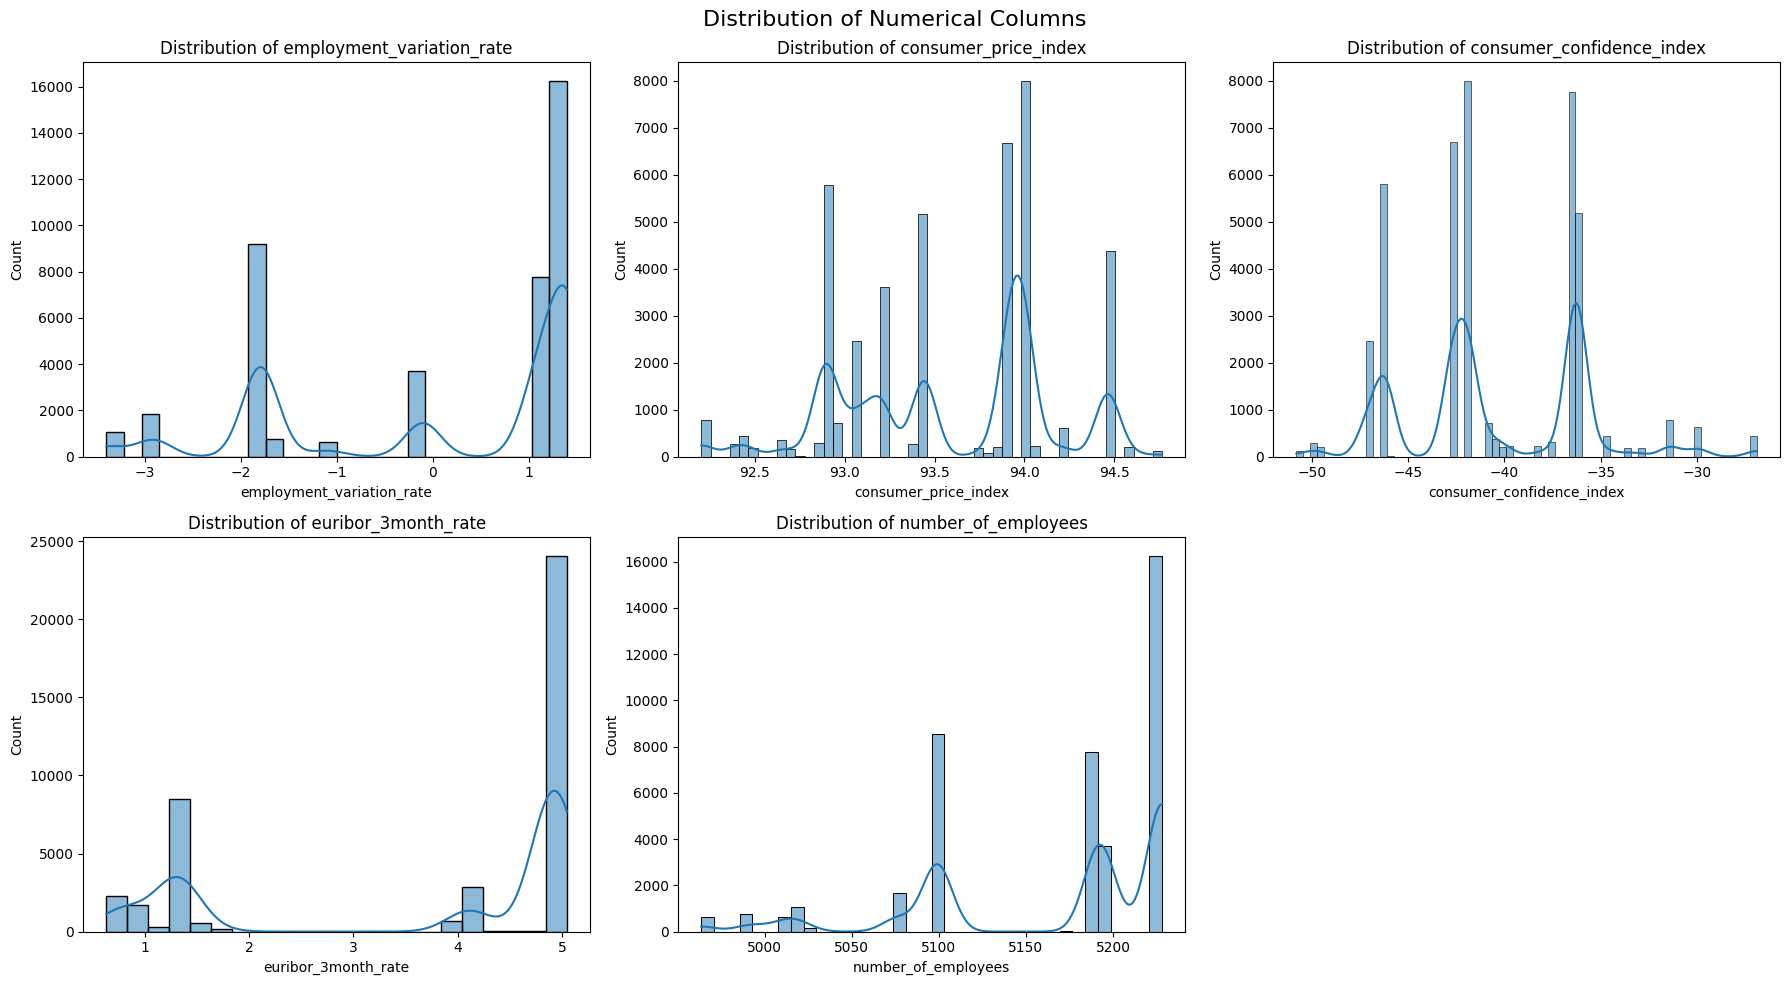

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, variable in enumerate(numerical_columns):
    row = i //3
    col = i % 3
    sns.histplot(df[variable], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {variable}')

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

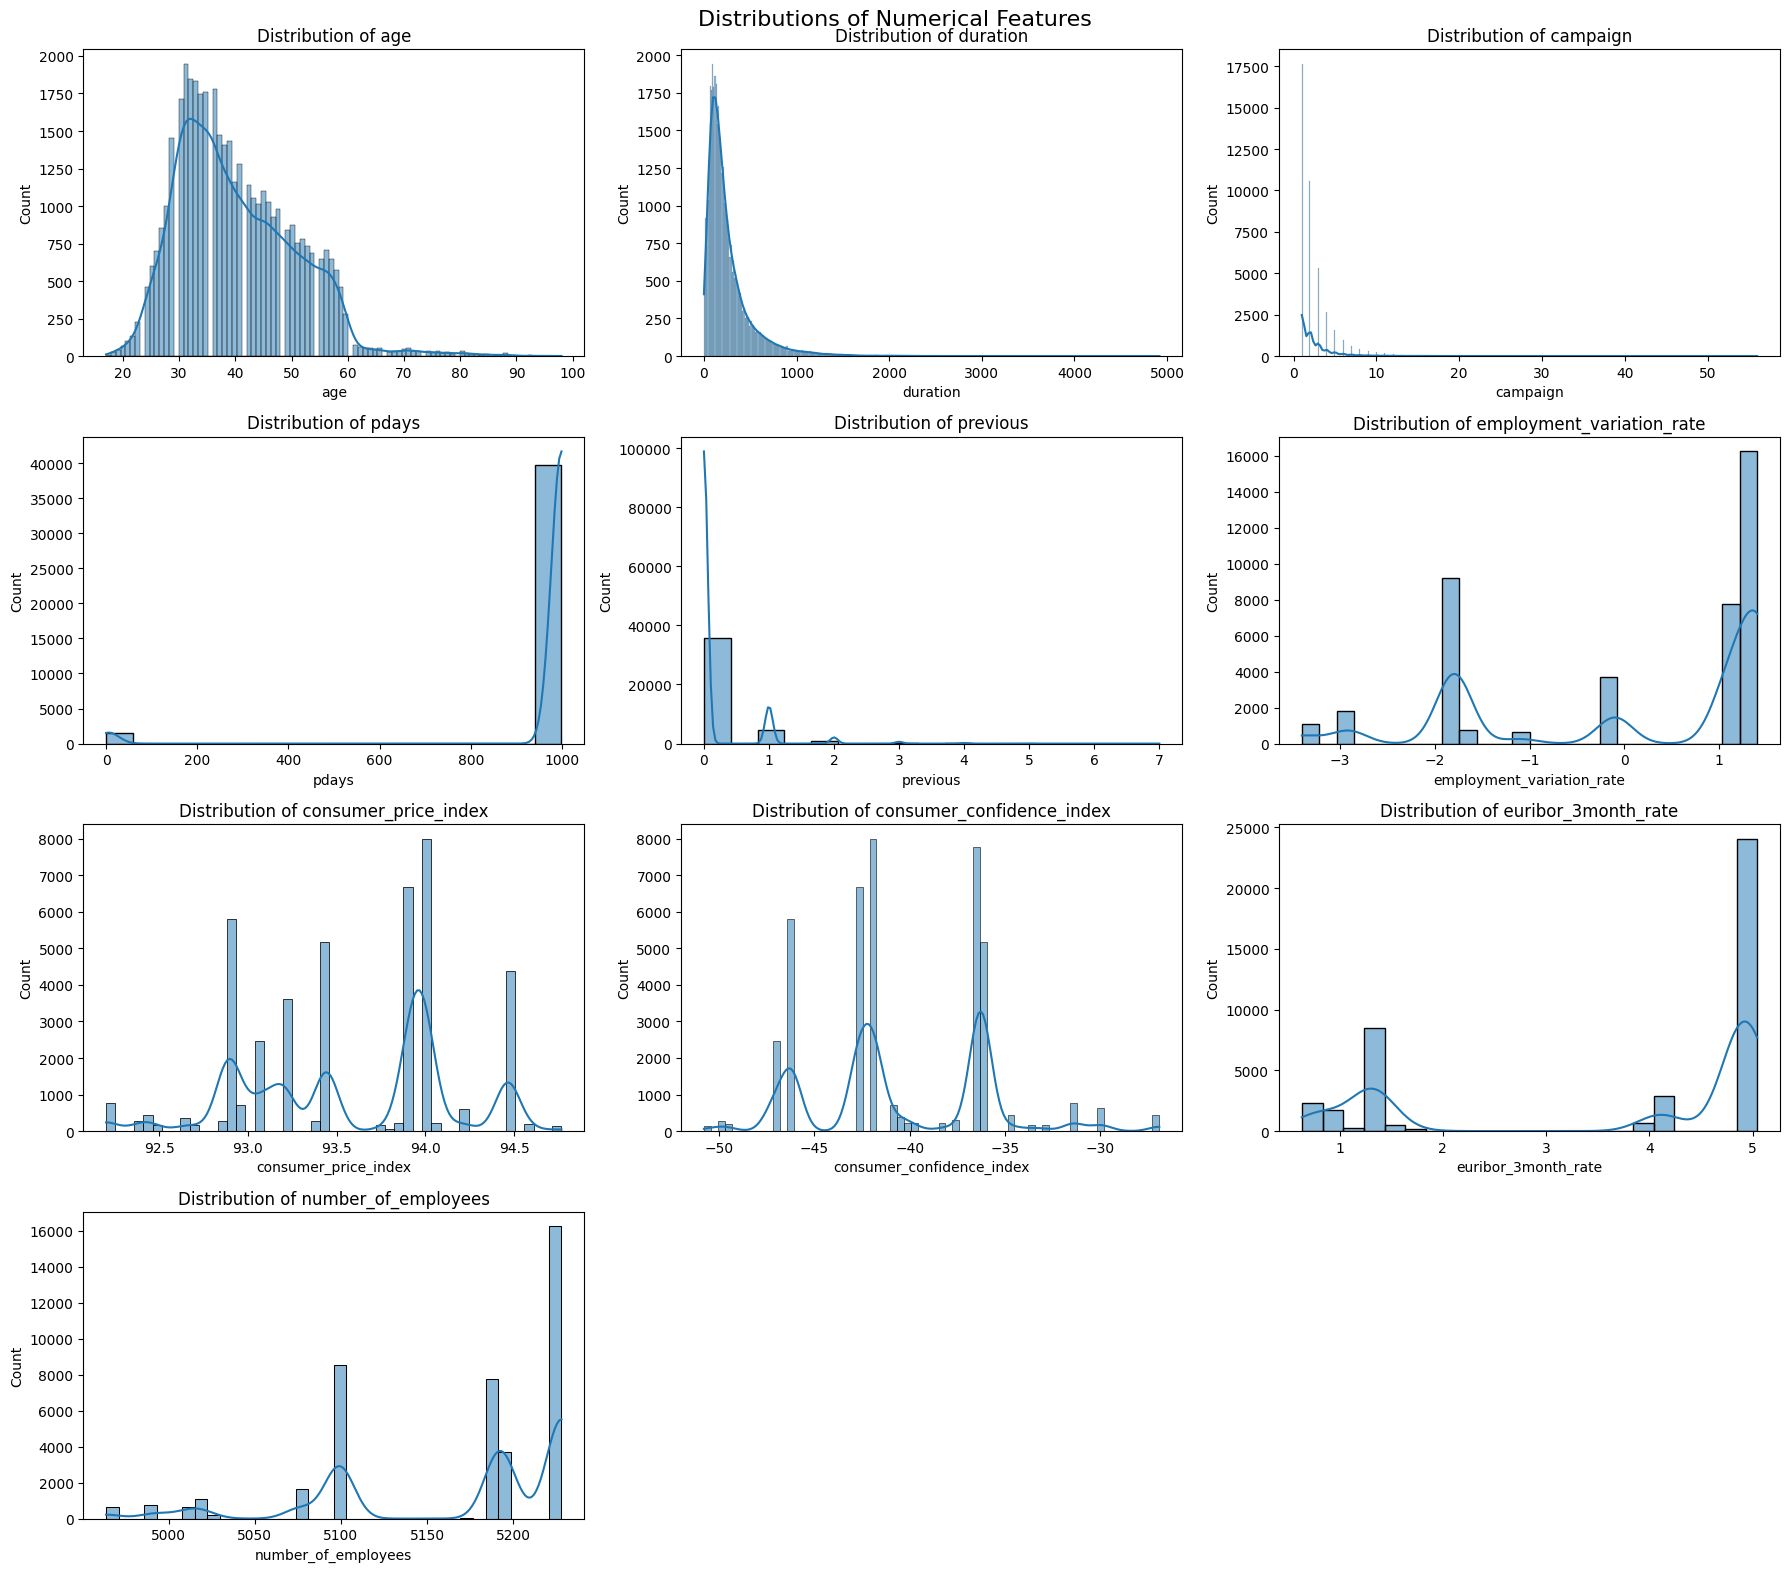

In [9]:
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                      'employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index',
                      'euribor_3month_rate', 'number_of_employees']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
fig.suptitle('Distributions of Numerical Features', fontsize=16)

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

for i in range(len(numerical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

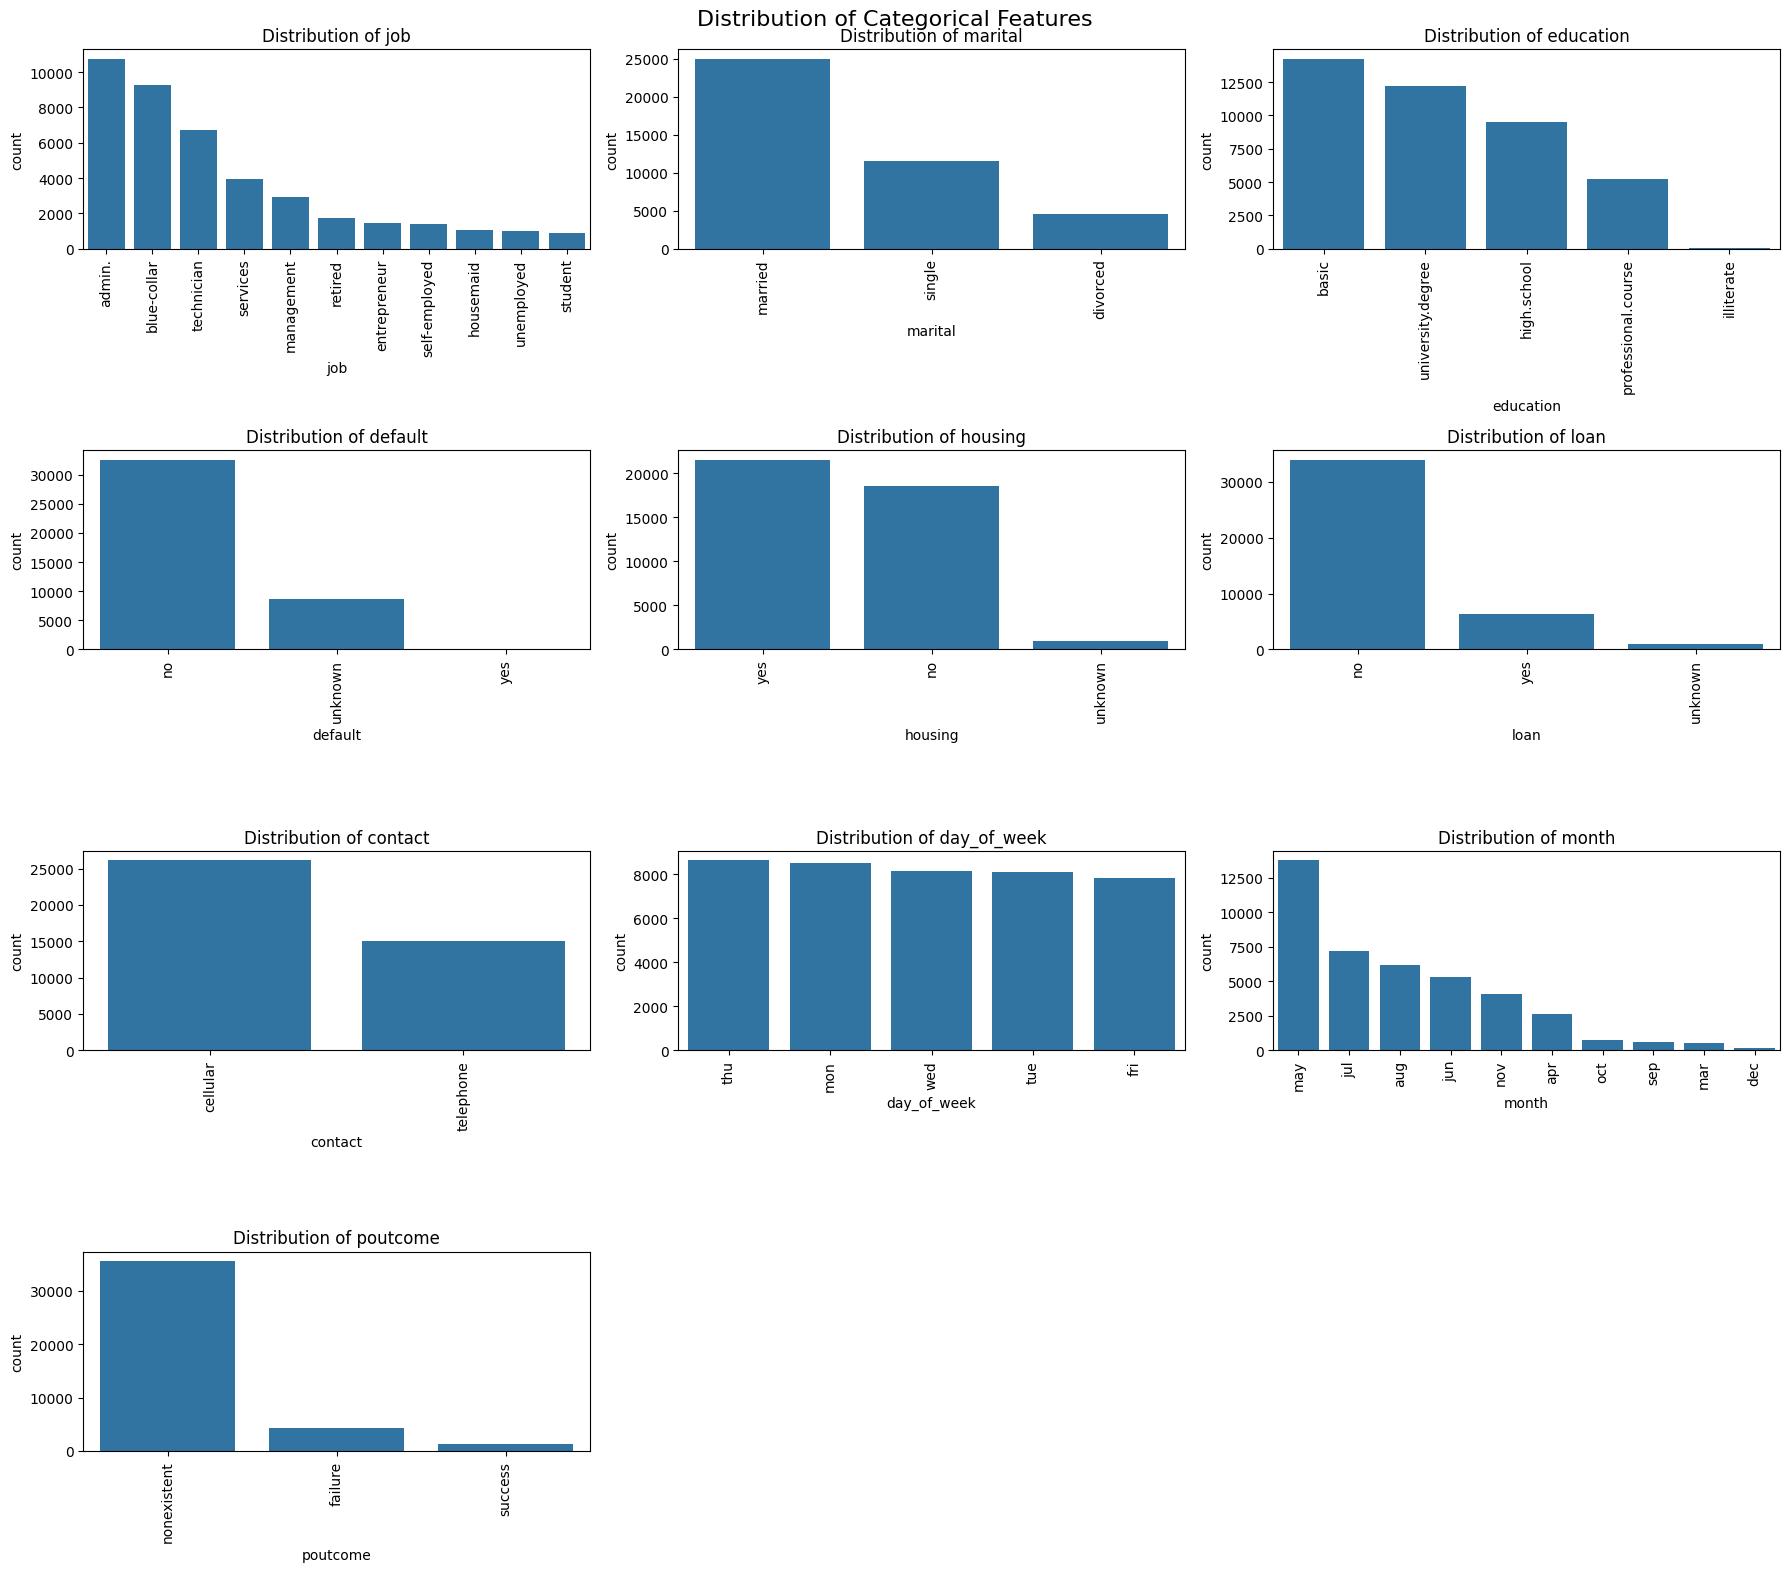

In [10]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'poutcome']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
fig.suptitle('Distribution of Categorical Features', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    sns.countplot(x=feature, data=df, ax=axes[row, col], order=df[feature].value_counts().index)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].tick_params(axis='x', rotation=90)

for i in range(len(categorical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

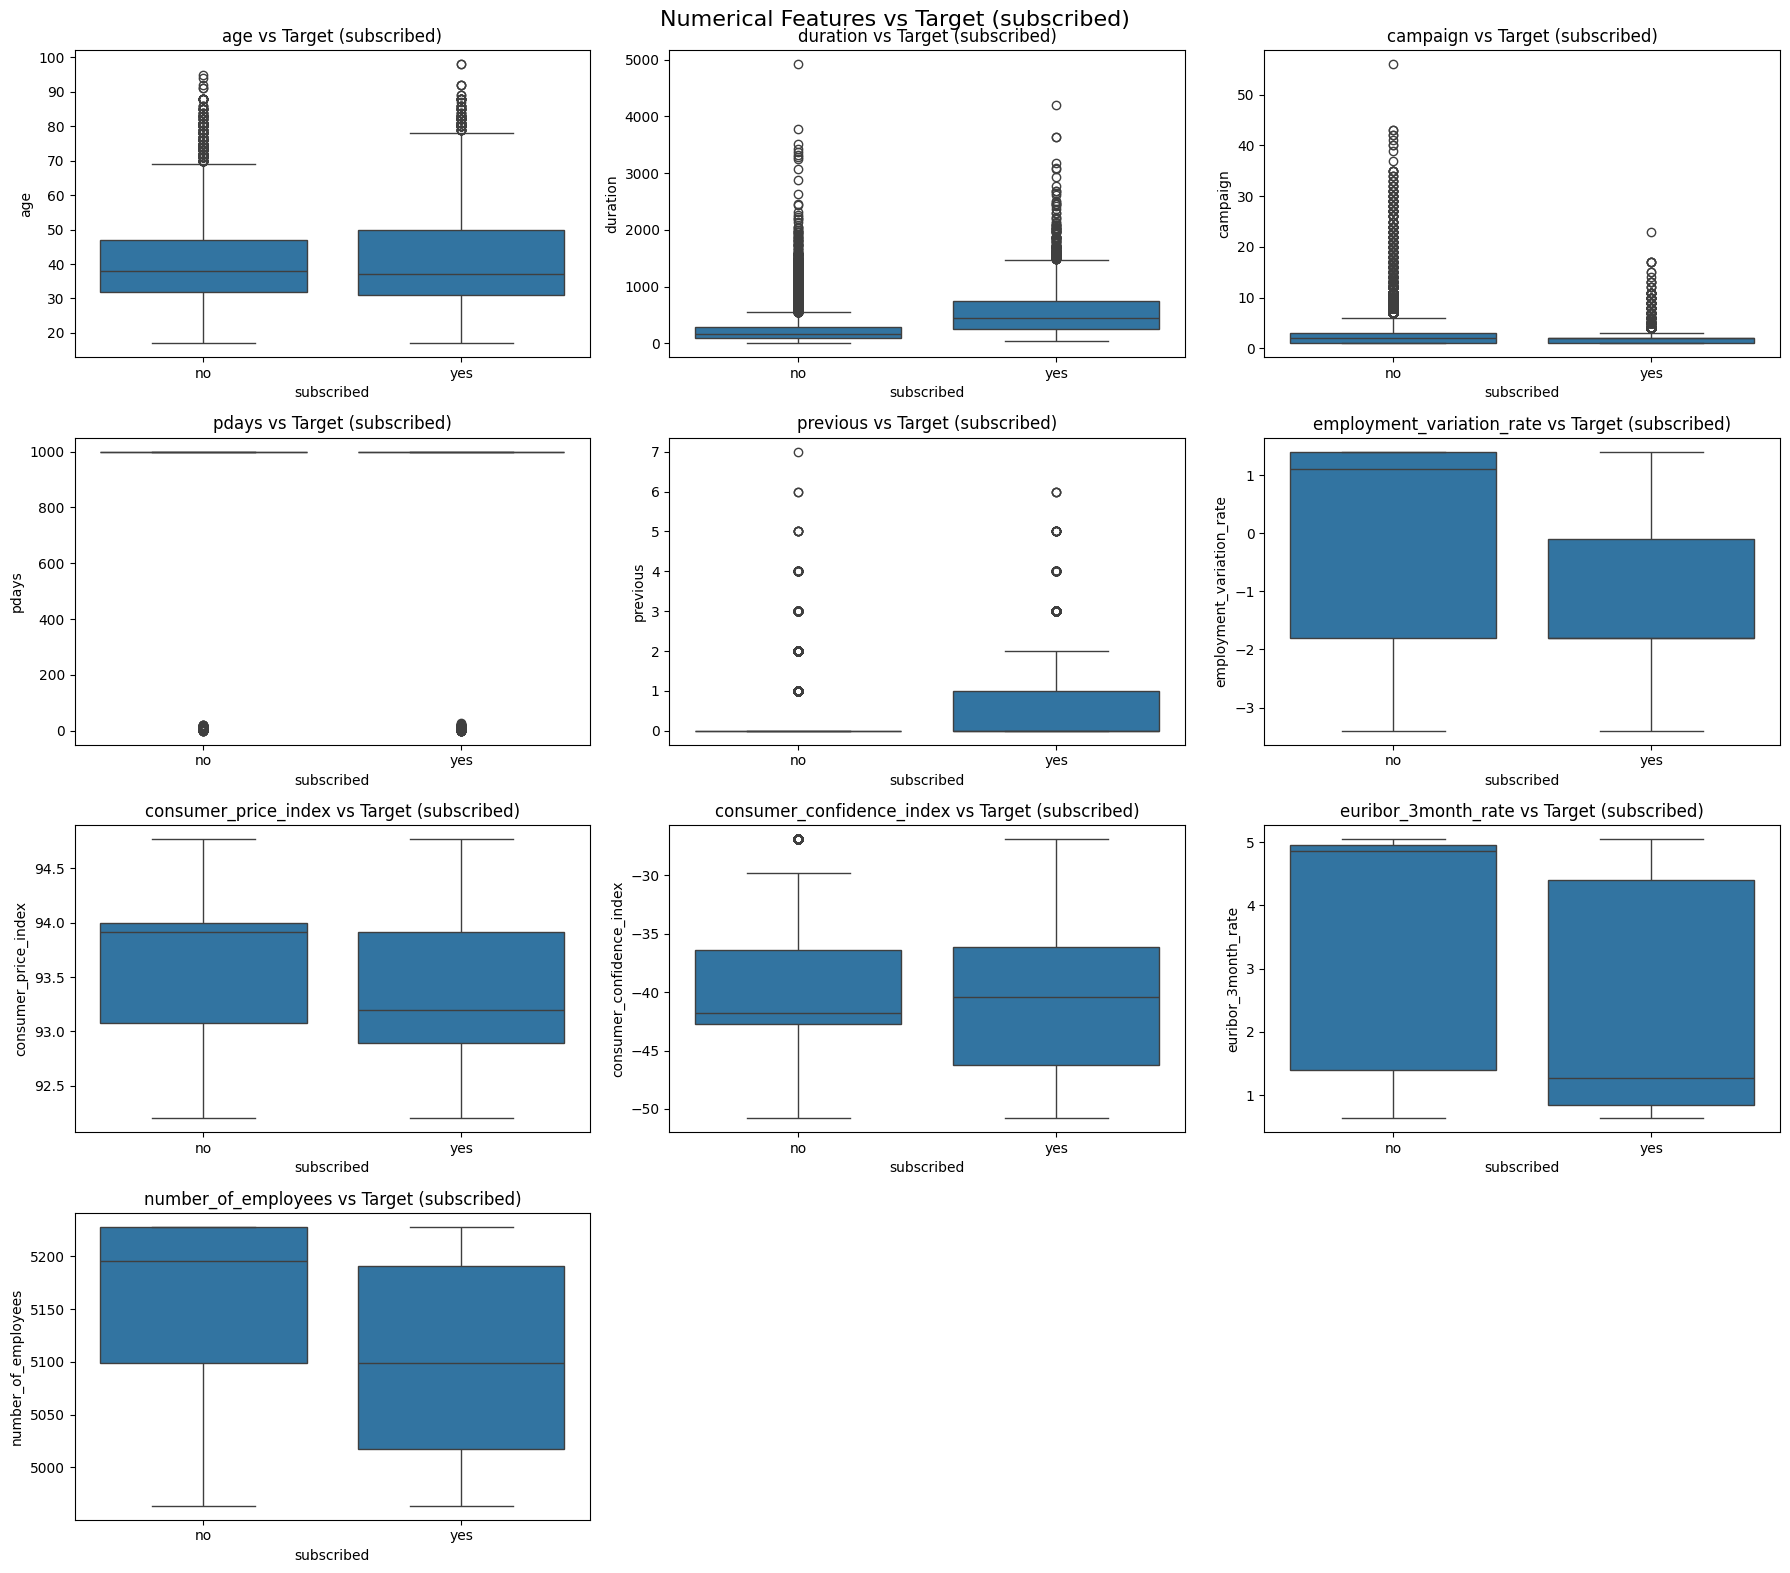

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
fig.suptitle('Numerical Features vs Target (subscribed)', fontsize=16)

for i, feature in enumerate(numerical_features):
    row = i // 3
    col = i % 3
    sns.boxplot(x='subscribed', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs Target (subscribed)')

for i in range(len(numerical_features), 12):
    fig.delaxes(axes.flatten()[i])


plt.tight_layout()
plt.show()

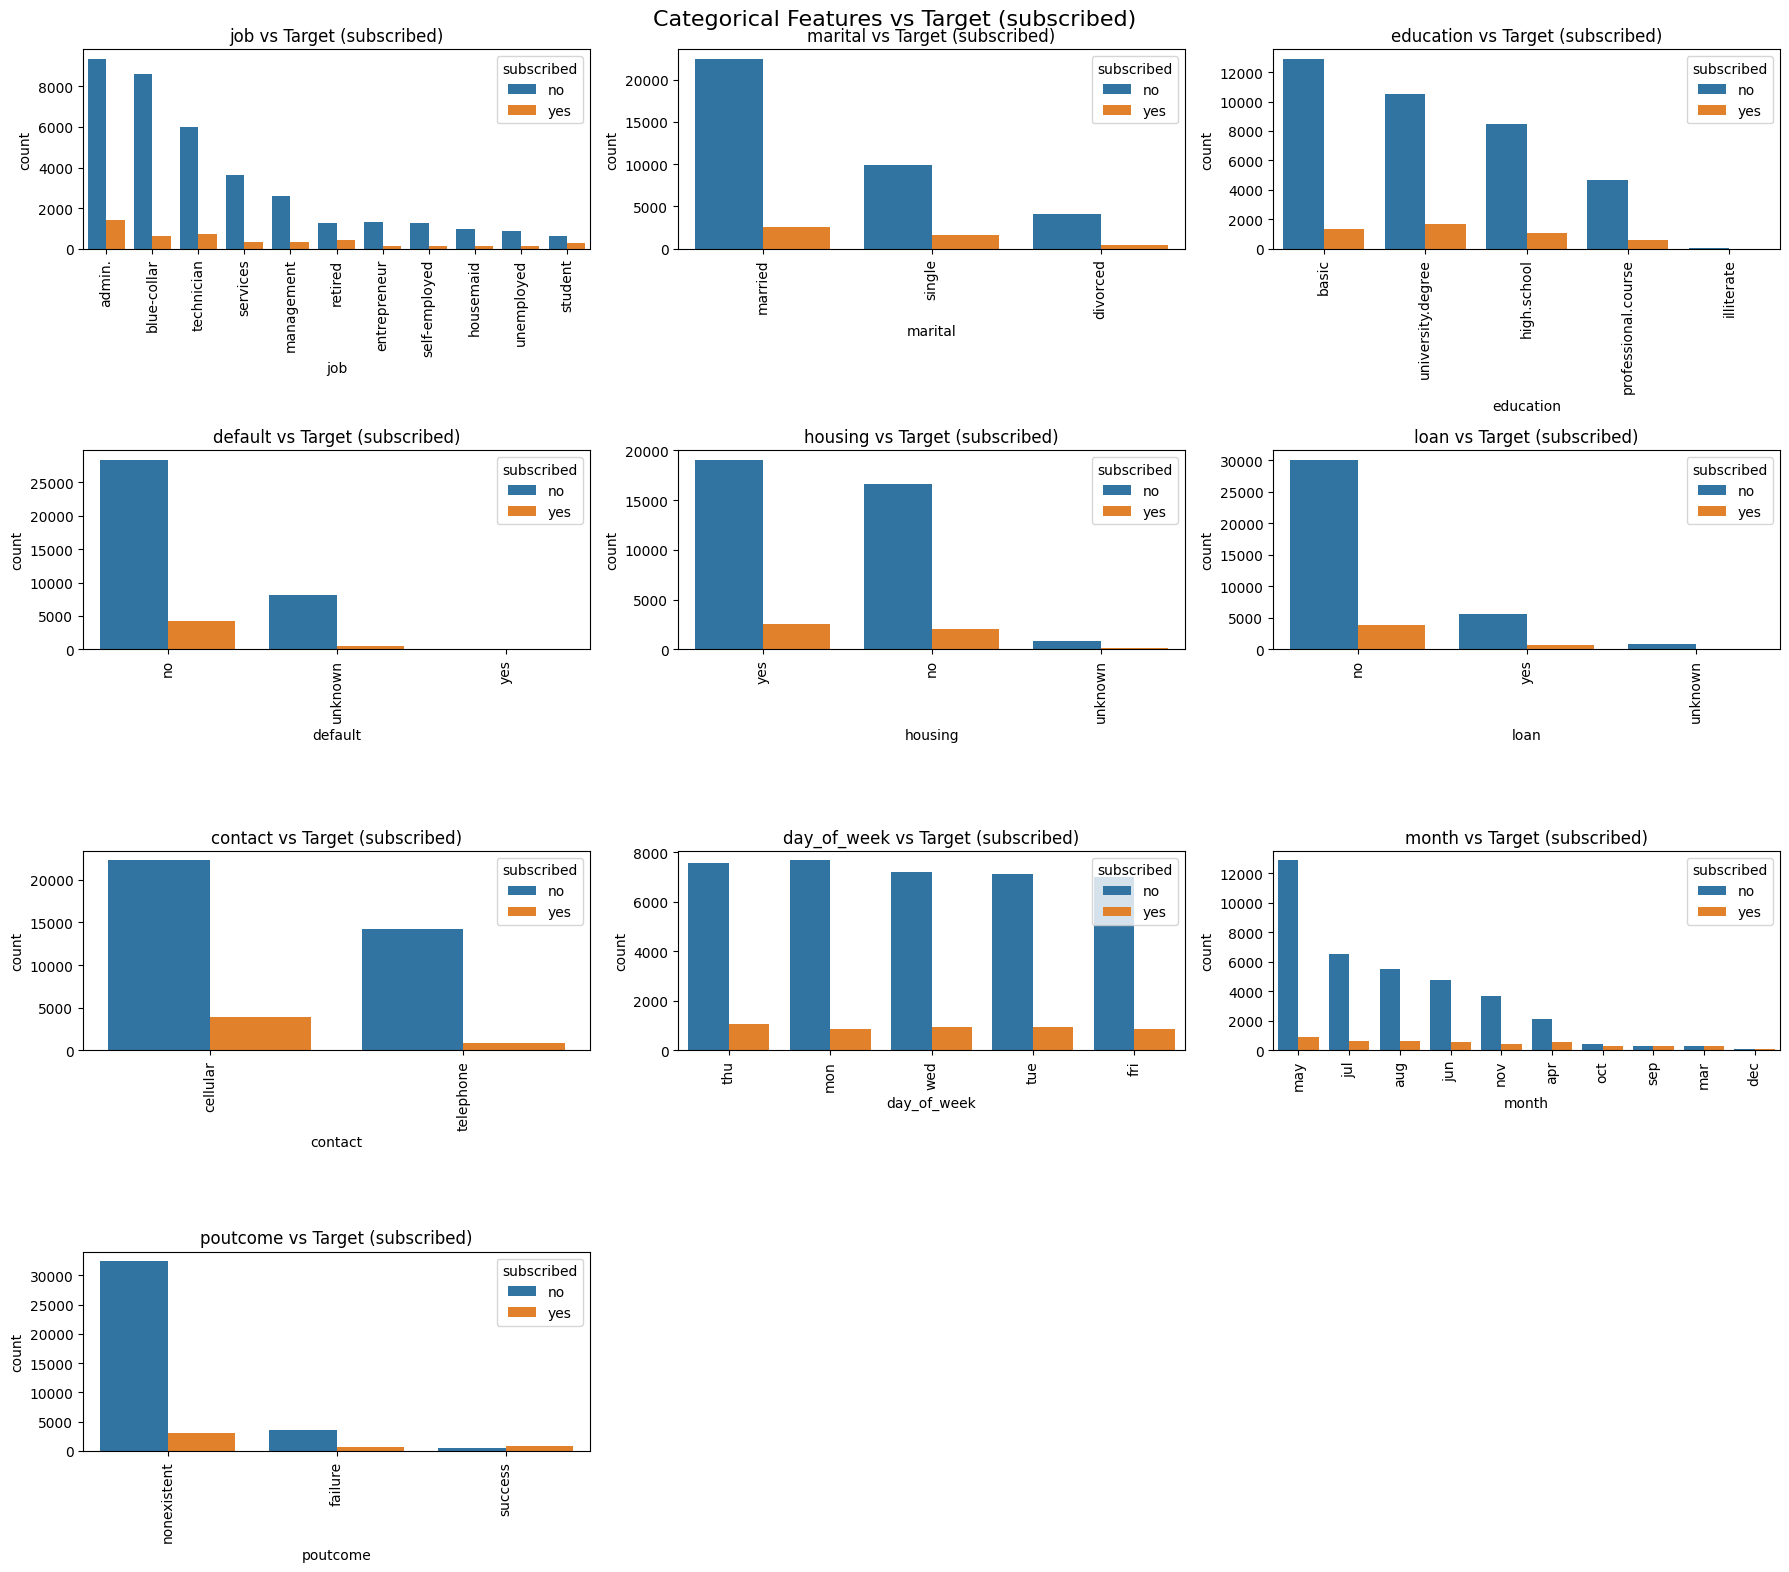

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18,16))
fig.suptitle('Categorical Features vs Target (subscribed)', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    sns.countplot(x=feature, hue='subscribed', data=df, ax=axes[row, col], order=df[feature].value_counts().index)
    axes[row, col].set_title(f'{feature} vs Target (subscribed)')
    axes[row, col].tick_params(axis='x', rotation=90)

for i in range(len(categorical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

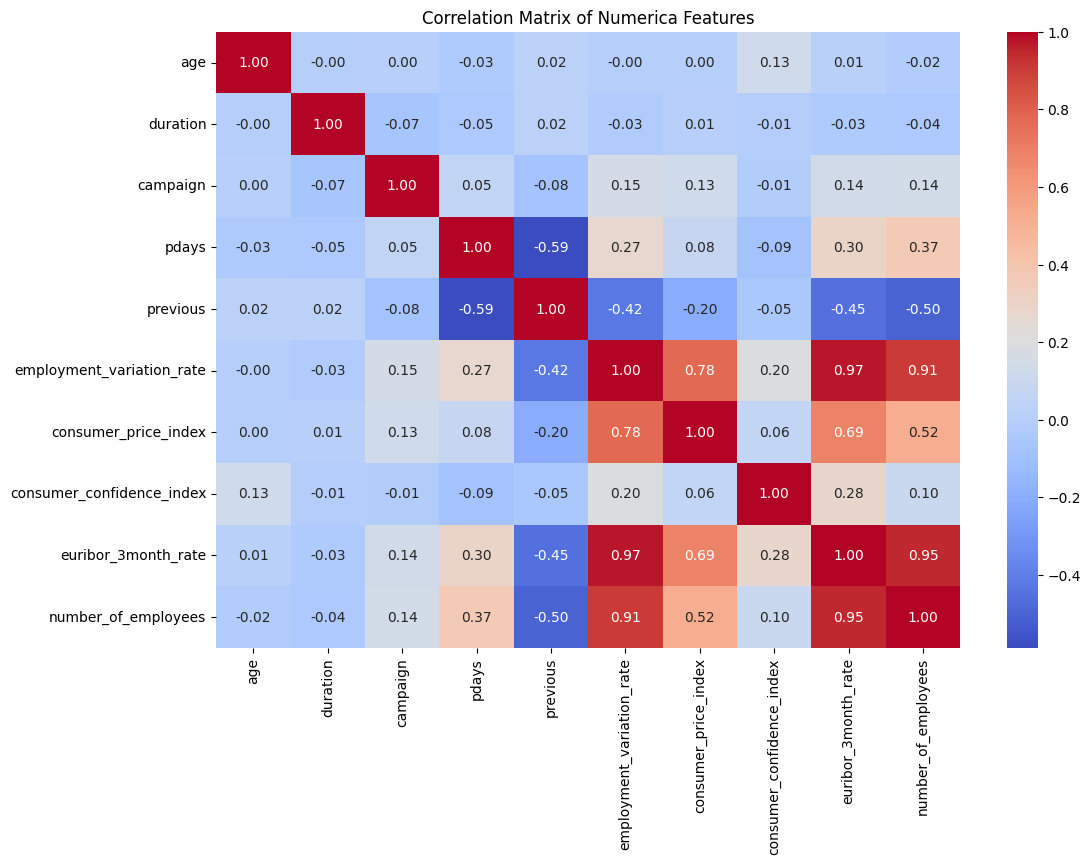

In [13]:
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerica Features')
plt.show()

## Data Preprocessing

In [14]:
# Drop highly correlated features
df = df.drop(['euribor_3month_rate', 'consumer_price_index'], axis=1)

In [15]:
# One-hot encode categorical features
categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

pd.set_option('future.no_silent_downcasting', True)

# Binary encode binary features
binary_features = ['default', 'housing', 'loan']
df[binary_features] = df[binary_features].replace({'yes': 1, 'no': 0, 'unknown': 2}).astype(int)

In [16]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['18-30', '31-50', '51+'])
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)

In [17]:
# Scale numerical features
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'employment_variation_rate', 'number_of_employees']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [18]:
X = df.drop('subscribed', axis=1)
y = df['subscribed'].replace({'yes': 1, 'no': 0}).astype(int)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

subscribed
0    29245
1    29245
Name: count, dtype: int64


## Model Building

### XGBoost

In [23]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [26]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [27]:
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9051
Precision: 0.5700
Recall: 0.6663
F1-Score: 0.6144
ROC-AUC: 0.9381


In [ ]:
# importances = initial_xgb_model.feature_importances_
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('XGBoost Feature Importance')
# plt.show()

In [ ]:
# less_important_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature']
# X_train_reduced = X_train_resampled.drop(less_important_features, axis=1)
# X_test_reduced = X_test.drop(less_important_features, axis=1)

In [ ]:
# xgb_model = XGBClassifier(random_state=42)
# xgb_model.fit(X_train_reduced, y_train_resampled)

# y_pred_xgb = xgb_model.predict(X_test_reduced)
# y_pred_proba_xgb = xgb_model.predict_proba(X_test_reduced)[:, 1]

In [ ]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_xgb)

# if np.isscalar(precision) or np.isscalar(recall):
#     raise ValueError("precision and recall must be arrays, not scalars.")

# # Plot precision-recall curve
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, precision[:-1], label='Precision')
# plt.plot(thresholds, recall[:-1], label='Recall')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.show()

In [ ]:
# f1_scores = 2 * (precision * recall) / (precision + recall)
# f1_scores = np.nan_to_num(f1_scores, nan=0)

# optimal_idx = np.argmax(f1_scores)
# optimal_threshold = thresholds[optimal_idx]

# print(f"Optimal Threshold: {optimal_threshold:.4f}")
# print(f"Max F1-Score: {f1_scores[optimal_idx]:.4f}")

In [ ]:
# y_pred_xgb_optimal = (y_pred_proba_xgb >= optimal_threshold).astype(int)

In [ ]:
# accuracy = accuracy_score(y_test, y_pred_xgb_optimal)
# precision = precision_score(y_test, y_pred_xgb_optimal)
# recall = recall_score(y_test, y_pred_xgb_optimal)
# f1 = f1_score(y_test, y_pred_xgb_optimal)
# roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")
# print(f"ROC-AUC: {roc_auc:.4f}")

In [ ]:
Accuracy: 0.8864
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.9357